In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.models import NLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError
import torch

torch.set_float32_matmul_precision('high')

In [3]:
base_path = 'stock_csv/'

column_mapping = {
    '일자': 'date',
    '종가': 'closing_price',
    '대비': 'price_difference',
    '등락률': 'fluctuation_rate',
    '시가': 'opening_price',
    '고가': 'highest_price',
    '저가': 'lowest_price',
    '거래량': 'trading_volume',
    '거래대금': 'trading_value',
    '시가총액': 'market_capitalization',
    '상장주식수': 'listed_shares',
}

In [4]:
stock_df = pd.read_excel(os.path.join(base_path, '005930_삼성전자_20000101_20230331.csv')).rename(columns=column_mapping)

stock_df.head()

,date,closing_price,price_difference,fluctuation_rate,opening_price,highest_price,lowest_price,trading_volume,trading_value,market_capitalization,listed_shares
0,2023/03/31,64000,800,1.27,64000,64000,63700,14094479,900711556583,382066083200000,5969782550
1,2023/03/30,63200,500,0.80,63700,63700,63100,15684377,993903387442,377290257160000,5969782550
2,2023/03/29,62700,-200,-0.32,62500,62700,62200,11216008,700455977590,374305365885000,5969782550
3,2023/03/28,62900,800,1.29,62400,62900,62100,11614118,726295104112,375499322395000,5969782550
4,2023/03/27,62100,-900,-1.43,62600,62800,62000,11039331,687170094400,370723496355000,5969782550


과거 공변량:
<ol>
    <li>과거 주가 데이터: 종가, 시가, 고가, 저가 등
    <li>거래량: 주식 거래량 데이터
    <li>기술적 지표: 이동 평균, RSI (상대 강도 지수), MACD (이동 평균 수렴 발산) 등
    <li>기업 재무 데이터: 매출, 이익, 자산, 부채 등
    <li>배당: 배당금과 배당 수익률
    <li>주가 수익률 (P/E) 등의 가치 지표
</ol>
<br>
미래 공변량:
<ol>
    <li>경제 성장률: 국내 총생산(GDP) 성장률 등
    <li>인플레이션: 소비자 물가지수(CPI) 등
    <li>기준 금리: 중앙은행의 기준 금리
    <li>실업률: 국가의 실업률 데이터
    <li>환율: 외환 시장의 환율 정보
    <li>경제 정책: 정부의 경제 정책이나 중앙은행의 통화 정책
</ol>

In [5]:
past_cov_list = ['price_difference', 'fluctuation_rate', 'opening_price', 'highest_price', 'lowest_price', 'trading_volume',
                'trading_value', 'market_capitalization', 'listed_shares']
# past_cov_list = []

def getScaledPastCov(timeseries):
    past_cov_timeseries = timeseries.copy()
    cov_year = datetime_attribute_timeseries(past_cov_timeseries, attribute='year')
    cov_month = datetime_attribute_timeseries(past_cov_timeseries, attribute='month')
    past_cov = cov_year.stack(cov_month)
    for col in past_cov_list:
        past_cov = past_cov.stack(past_cov_timeseries[col])
    return Scaler().fit_transform(past_cov)

def getFutureCov(timeseries):
    pass

In [6]:
def write_pickle(file_path, data):
    with open(file_path, "wb") as f:
        pickle.dump(df, f)

def read_pickle(file_path):
    with open(file_path, "rb") as f:
        result = pickle.load(f)
    return result

In [7]:
"""
    아래 코드의 속도 개선 중
"""
import time
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
start_time = time.time()


start_date = '2015-01-01'
end_date = '2023-03-31'

interpolate_list = ['closing_price'] + past_cov_list

list_stock_timeseries = []

list_train_series_scaled = []
list_val_series_scaled = []
list_scaler = []

list_scaled_past_cov = []
list_train_scaled_past_cov = []
list_val_scaled_past_cov = []

list_scaled_future_cov = []
list_train_scaled_future_cov = []
list_val_scaled_future_cov = []

for i, file_name in enumerate(os.listdir(base_path)):
    print(i, file_name)
    df = pd.read_excel(base_path + file_name).rename(columns=column_mapping)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    if len(df.loc[:start_date]) == 0: # start_date 이전 날짜 데이터가 없는 경우는 무시. 따라서 start_date 이후 상장된 주식은 훈련 X
        continue
    df = df.loc[start_date:end_date]
    # 9.68초
    
    # Date interpolate
    stock_timeseries_df_interpolated = df.copy()
    stock_timeseries_df_interpolated = stock_timeseries_df_interpolated.asfreq('B')
    for col in interpolate_list:
        stock_timeseries_df_interpolated[col] = stock_timeseries_df_interpolated[col].interpolate(method='linear')
    df = stock_timeseries_df_interpolated
    # 25.73초
    
    # 전처리 결과를 저장 -> 마지막 줄에서 pickle 저장하는 것이 좋아보임
#     df.to_excel('interpolated_' + base_path + file_name)
    
    timeseries = TimeSeries.from_dataframe(df)
    # 40.93초
    
    
    # Darts TimeSeries 변환 및 날짜 필터링
    stock_timeseries = timeseries['closing_price']
    list_stock_timeseries.append(stock_timeseries)

    # Past covariant 및 날짜 필터링
    scaled_past_cov_timeseries = getScaledPastCov(timeseries)
    list_scaled_past_cov.append(scaled_past_cov_timeseries)
    # 159.89초
    
    # Split train/validation set
    train_percentage = 0.8
    split_index = int(train_percentage * len(stock_timeseries))
    
    train_series, val_series = stock_timeseries[:split_index], stock_timeseries[split_index:]
    train_past_cov_series, val_past_cov_series = scaled_past_cov_timeseries[:split_index], scaled_past_cov_timeseries[split_index:]
    
    list_train_scaled_past_cov.append(train_past_cov_series)
    list_val_scaled_past_cov.append(val_past_cov_series)
    
    # Scale
    scaler = Scaler()
    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    list_scaler.append(scaler)
    
    list_train_series_scaled.append(train_series_scaled)
    list_val_series_scaled.append(val_series_scaled)

print(time.time() - start_time)
# Reset warning filter
warnings.filterwarnings('default')

0 000660_SK하이닉스_20000101_20230331.csv
1 005930_삼성전자_20000101_20230331.csv
2 007070_GS리테일_20000101_20230331.csv
3 015760_한국전력_20000101_20230331.csv
4 027410_BGF_20000101_20230331.csv
5 034730_SK_20000101_20230331.csv
6 047810_한국항공우주_20000101_20230331.csv
7 055550_신한지주_20000101_20230331.csv
8 078930_GS_20000101_20230331.csv
9 086790_하나금융지주_20000101_20230331.csv
10 088980_맥쿼리인프라_20000101_20230331.csv
11 105560_KB금융_20000101_20230331.csv
12 282330_BGF리테일_20000101_20230331.csv
13 316140_우리금융지주_20000101_20230331.csv
12.03958511352539


In [8]:
interpolate_list = ['closing_price'] + past_cov_list

# 필터링할 날짜 범위 설정
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-03-31')

list_stock_timeseries = []

list_train_series_scaled = []
list_val_series_scaled = []
list_scaler = []

list_scaled_past_cov = []
list_train_scaled_past_cov = []
list_val_scaled_past_cov = []

list_scaled_future_cov = []
list_train_scaled_future_cov = []
list_val_scaled_future_cov = []

for i, file_name in enumerate(os.listdir(base_path)):
    print(i, file_name)
    df = pd.read_excel(base_path + file_name).rename(columns=column_mapping)
    if len(df) < 100:
        continue
    df['date'] = pd.to_datetime(df['date'])
    
    # Date interpolate
    stock_timeseries_df_interpolated = df.copy()
    stock_timeseries_df_interpolated.set_index('date', inplace=True)
    stock_timeseries_df_interpolated = stock_timeseries_df_interpolated.asfreq('B')
    for col in interpolate_list:
        stock_timeseries_df_interpolated[col] = stock_timeseries_df_interpolated[col].interpolate(method='linear')
    stock_timeseries_df_interpolated.reset_index(inplace=True)
    df = stock_timeseries_df_interpolated
    
    # Interpolate 확인
#     print(df.isna().sum())

    timeseries = TimeSeries.from_dataframe(df, time_col='date', freq='B')
    
    
    # Darts TimeSeries 변환 및 날짜 필터링
    stock_timeseries = timeseries['closing_price']
    stock_timeseries = stock_timeseries[start_date:end_date]
    list_stock_timeseries.append(stock_timeseries)

    # Past covariant 및 날짜 필터링
    scaled_past_cov_timeseries = getScaledPastCov(timeseries)
    scaled_past_cov_timeseries = scaled_past_cov_timeseries[start_date:end_date]
    list_scaled_past_cov.append(scaled_past_cov_timeseries)
    
    # Split train/validation set
    train_percentage = 0.8
    split_index = int(train_percentage * len(stock_timeseries))
    
    train_series, val_series = stock_timeseries[:split_index], stock_timeseries[split_index:]
    train_past_cov_series, val_past_cov_series = scaled_past_cov_timeseries[:split_index], scaled_past_cov_timeseries[split_index:]
    
    list_train_scaled_past_cov.append(train_past_cov_series)
    list_val_scaled_past_cov.append(val_past_cov_series)
    
    # Scale
    scaler = Scaler()
    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    list_scaler.append(scaler)
    
    list_train_series_scaled.append(train_series_scaled)
    list_val_series_scaled.append(val_series_scaled)
    
#     if i % 50 == 49:
#         break

0 000660_SK하이닉스_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


1 005930_삼성전자_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
Exception ignored in: <function ZipFile.__del__ at 0x000001E07A974F70>
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\lib\zipfile.py", line 1816, in __del__
    self.close()
KeyboardInterrupt: 
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


2 007070_GS리테일_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


3 015760_한국전력_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


4 027410_BGF_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


5 034730_SK_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


6 047810_한국항공우주_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


7 055550_신한지주_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


8 078930_GS_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


9 086790_하나금융지주_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


10 088980_맥쿼리인프라_20000101_20230331.csv


c:\Users\Admin\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


In [26]:
logger = TensorBoardLogger('logs', name='my_model')

# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MetricCollection([MeanAbsoluteError(), MeanSquaredError()])

# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsoluteError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper], "logger": logger}

model = NLinearModel(input_chunk_length=20, output_chunk_length=5, n_epochs=10, random_state=42,
                        torch_metrics=torch_metrics,
                        pl_trainer_kwargs=pl_trainer_kwargs)
model.fit(list_train_series_scaled,
            past_covariates=list_train_scaled_past_cov,
            # future_covariates=list_train_scaled_future_cov
            val_series=list_val_series_scaled,
            val_past_covariates=list_val_scaled_past_cov,
            # val_future_covariates=list_val_scaled_future_cov
            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [27]:
model_path = "model/all_past.pkl"
if not os.path.exists('model'):
    os.mkdir('model')
model.save(model_path)
model_loaded = NLinearModel.load(model_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")


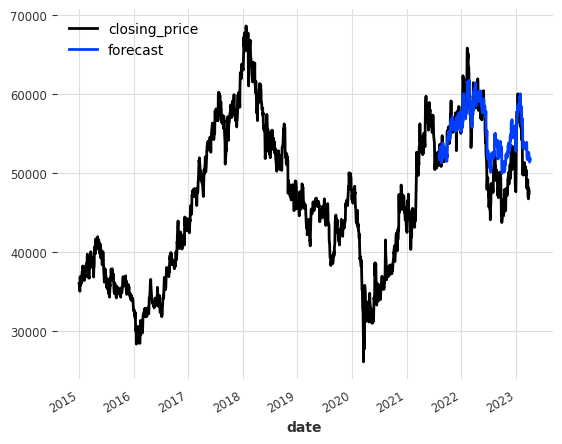

In [28]:
i = 11
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i])+5,
                                        series=list_train_series_scaled[i],
                                        past_covariates=list_scaled_past_cov[i],
                                        # future_covariates=list_scaled_future_cov[i],
                                        )
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i].plot()
prediction.plot(label="forecast")
plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
c:\Users\Admin\anaconda3\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")


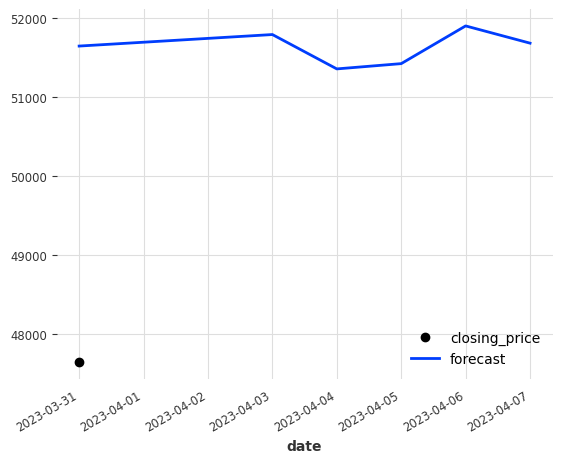

In [29]:
i = 11
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i])+5,
                                        series=list_train_series_scaled[i],
                                        past_covariates=list_scaled_past_cov[i],
                                        # future_covariates=list_scaled_future_cov[i],
                                        )
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i][pd.to_datetime('2023-03-31'):].plot()
prediction[pd.to_datetime('2023-03-31'):].plot(label="forecast")
plt.legend()